## Multi Modal Rag App

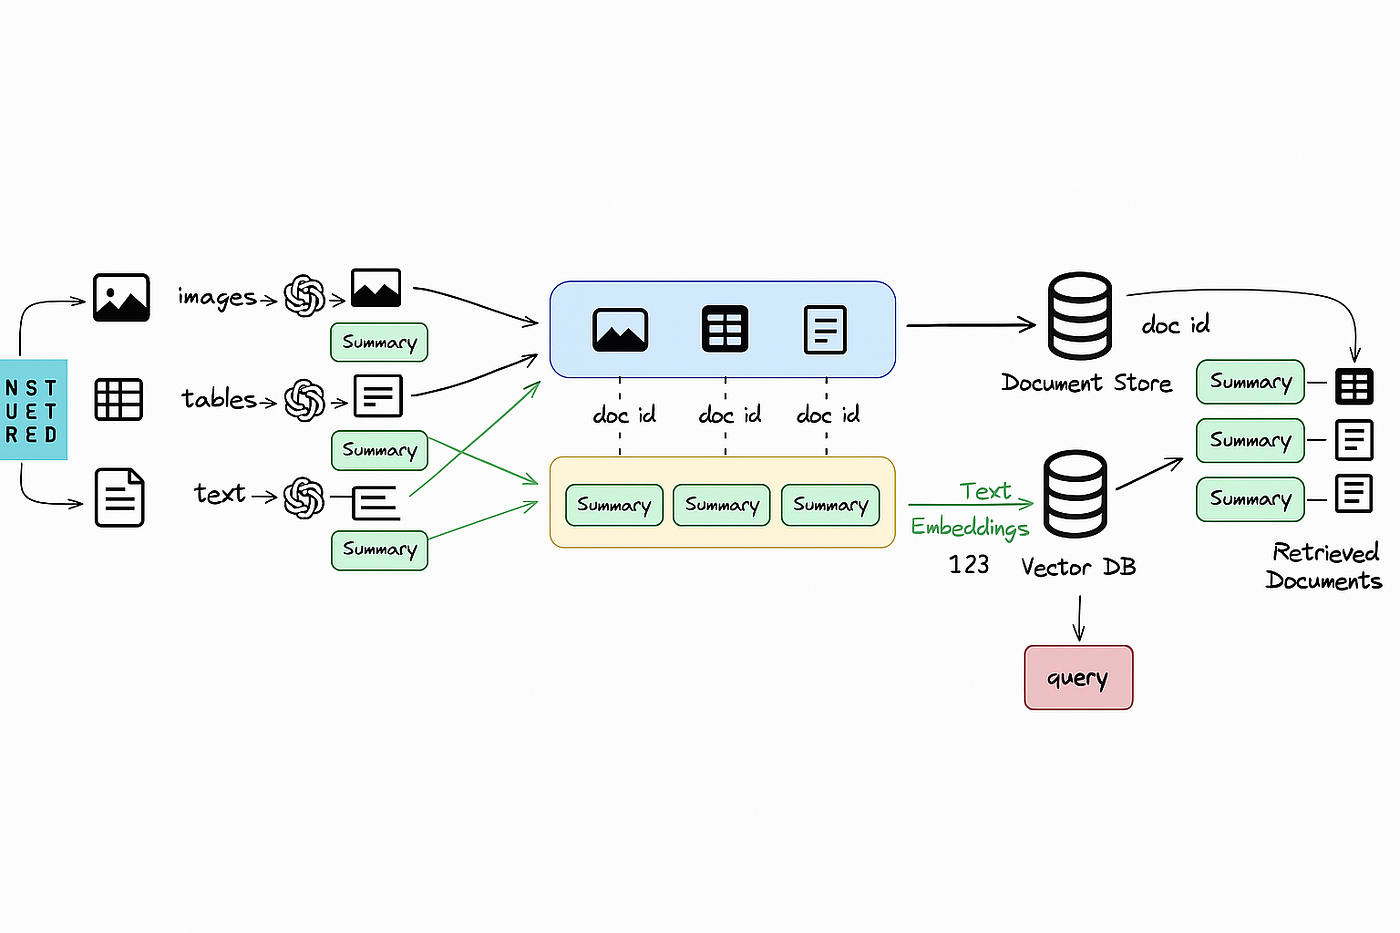

In [31]:
from IPython.display import display, Image

display(Image(filename='Data/diagram.png'))

In [32]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [33]:
# Langsmith
os.environ["LANGSMITH_TRACING"]= "true"
os.environ["LANGSMITH_API_KEY"]= os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"]= os.getenv("LANGSMITH_PROJECT")
# Groq
os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")

### Extract the Data

In [34]:
# import pytesseract

# # Replace with your actual path
# pytesseract.pytesseract.tesseract_cmd = r"C:\Users\HP\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"

# import os
# os.environ["TESSDATA_PREFIX"] = r"C:\Users\HP\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"

In [35]:
from unstructured.partition.pdf import partition_pdf

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename="Data/attention.pdf",
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,
    # extract_images = True

    # extract_images_in_pdf=True,          # deprecated
)

In [36]:
len(chunks)

9

In [37]:
chunks[0].to_dict()

{'type': 'CompositeElement',
 'element_id': '8fb6719f9c92e14a89c470f2bb1b45f0',
 'text': 'Attention Is All You Need\n\nAshish Vaswani∗ Google Brain avaswani@google.com\n\nNoam Shazeer∗ Google Brain noam@google.com\n\nNiki Parmar∗\n\nGoogle Research nikip@google.com\n\nJakob Uszkoreit∗ Google Research usz@google.com\n\nLlion Jones∗ Google Research llion@google.com\n\nAidan N. Gomez∗ † University of Toronto aidan@cs.toronto.edu\n\nŁukasz Kaiser∗ Google Brain lukaszkaiser@google.com\n\nIllia Polosukhin∗ ‡\n\nillia.polosukhin@gmail.com\n\nAbstract\n\nThe dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show t

In [38]:
chunks[0].metadata.orig_elements

In [39]:
from unstructured.documents.elements import Image
import json

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if isinstance(el, Image)]
if chunk_images:
    img_dict = chunk_images[0].to_dict()
    print(json.dumps(img_dict, indent=2))
else:
    print("No images found in this chunk.")

{
  "type": "Image",
  "element_id": "c3482ee7-eaa6-451e-a2e3-51ceb59038d8",
  "text": "",
  "metadata": {
    "coordinates": {
      "points": [
        [
          486.0,
          261.1805555555558
        ],
        [
          486.0,
          614.7805555555556
        ],
        [
          664.0,
          614.7805555555556
        ],
        [
          664.0,
          261.1805555555558
        ]
      ],
      "system": "PixelSpace",
      "layout_width": 1700,
      "layout_height": 2200
    },
    "last_modified": "2025-08-12T21:56:30",
    "filetype": "PPM",
    "languages": [
      "eng"
    ],
    "page_number": 4,
    "image_base64": "/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiALIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII

## Separate Extracted Elements into tables, Text and Images

In [2]:
#Separate tables from texts

tables= []
texts = []

for chunk in chunks:
    if "Table" in str(type(chunks)):
        tables.append(chunk)
    elif "CompositeElement" in str(type(chunk)):
        texts.append(chunk)

NameError: name 'chunks' is not defined

In [ ]:
# Get the Image from Composite Element Objects
from typing import List

def get_images_b64(chunks)-> List:
    image_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunks)):
            chunks_elements = chunk.metadata.orig_elements
            for element in chunks_elements:
                if "Image" in str(type(element)):
                    image_b64.append(element.metadata.image_base64)
    return image_b64

images = get_images_b64(chunks) 

In [ ]:
#Displaying the Image

import base64
from IPython.display import display, Image

def display_base64_image(base_64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base_64_code)
    # Display the Image
    display(Image(data=image_data))

display_base64_image(images[0])

## Summarize the Data

* Create a summary of each element extracted from the PDF. This Summary will be vectorized and used in the retrieval process.

### Text and Table Summaries

In [3]:
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [4]:
# Prompt
prompt_text = """
You are an helpful assitant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additional comment.
Do not start your message by saying "Here is a Summary" or anything like that.

Table or text chunk: {element}
"""

prompt = ChatPromptTemplate.from_template(prompt_text)

In [ ]:
# Initializing the model
model = ChatGroq(model="", temperature=0.4)
summarizer_chain = (prompt | model | StrOutputParser())

In [ ]:
print(texts[0])

In [6]:
# Summarize Text
text_summaries = summarizer_chain.batch(texts, {"max_concurrency": 3})

# Summarize Tables
tables_html  = [table.metadata.text_as_html for table in tables]
table_summaries = summarizer_chain.batch(tables_html, {"max_concurrency": 3})

NameError: name 'summarizer_chain' is not defined

In [ ]:
text_summaries

In [ ]:
table_summaries

## Image Summaries

In [ ]:
prompt_template = """Describe the image in detail. 
                    For Context, the image is a part of a pdf or a document. 
                    Be specific about the graphs, such as bar plots."""

In [ ]:
image_model = "meta-llama/llama-4-scout-17b-16e-instruct"

from groq import Groq
import os

client = Groq(api_key=os.environ.get("GROQ_API_KEY"))
completion = client.chat.completions.create(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt_template
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "data:image/jpeg;base64,{image}"
                    }
                }
            ]
        }
    ],
    temperature=1,
    max_completion_tokens=1024,
    top_p=1,
    stream=False,
    stop=None,
)


# 

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | image_model | StrOutputParser()

image_summaries = chain.batch(images)

## Load Data and Summaries into Vector Store

### Create the Vector Store

In [ ]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
